# Building a Reinforcement Learning Guided Fuzz Testing Engine for Binary Search Trees

In this tutorial, we will show how Atlas enables us to turn a dumb fuzzer into an effective rl-guided one.

Full paper with more in-depth examples coming soon!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## A Binary Search Tree Class
Let's first define a binary search tree class. 

In [10]:
# A binary search tree class
class BinarySearchTree:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        
        # Useful for checking if tree is valid. See the `is_bst` method for details
        self.min_val = value
        self.max_val = value

    def insert(self, val):
        """ Insert val into the tree """
        if self.value == val:
            return
        
        if self.value > val:
            if self.left:
                self.left.insert(val)
            else:
                self.left = BinarySearchTree(val)
        else:
            if self.right:
                self.right.insert(val)
            else:
                self.right = BinarySearchTree(val)
        
    def reduce_min_max(self, op):
        result_left = self.value if self.left is None else self.left.reduce_min_max(op)
        result_right = self.value if self.right is None else self.right.reduce_min_max(op)
        return op(self.value, result_left, result_right)
            
    def is_bst(self):
        """
        Check whether the tree satisfies the binary search tree invariant.
        That is, left child is a BST, right child is a BST, and self's value
        is greater than the left child's value and smaller than the right
        child's value.
        """
        left_ok = True if not self.left else (self.left.is_bst() and self.value > self.left.reduce_min_max(max))
        right_ok = True if not self.right else (self.right.is_bst() and self.value < self.right.reduce_min_max(min))
        return right_ok and left_ok

    def __repr__(self, indent=0):
        left_repr = self.left.__repr__(indent + 1) if self.left else " None"
        right_repr = self.right.__repr__(indent + 1) if self.right else " None"
        return f"({self.value}\n{indent*'  '}L{left_repr}\n{indent*'  '}R{right_repr})"


Say we want to test our insert function. One way to do this is to fuzz test: we'll generate many random trees, and try to insert random numbers into them, and check that the tree is still a binary search tree after insertion.

Because we're lazy, let's just write a generator that generates any binary search tree:

In [15]:
from atlas import generator

MAX_DEPTH = 4

@generator(strategy='randomized')
def generate_tree(depth=0):
    value = Select(range(0, 11))
    tree = BinarySearchTree(value)
    #  Randomly add left and right child without using semantics of insert
    if depth < MAX_DEPTH and Select([True, False]):
        tree.left = generate_tree(depth+1)
    if depth < MAX_DEPTH and Select([True, False]):
        tree.right = generate_tree(depth+1) 
    return tree 

Because we're lazy, this may not actually create trees that satisfy the binary search tree invariant. We can still use it for fuzzing if we call it enough times:

In [24]:
import random
TRIALS=10000

# Keep track of the valid BSTs we generate
def fuzz():
    num_bsts = 0
    unique_bsts = set()
    
    for n in range(1, TRIALS+1):
        tree = generate_tree.call()
        tree_repr = tree.__repr__()
    
        if tree.is_bst():
            num_bsts += 1
            unique_bsts.add(tree_repr)
            
        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
        
    return unique_bsts

How well do we do with this randomized generation strategy?

In [25]:
bsts = fuzz()

1812 trials, 576 binary search trees, 96 unique BSTs

3318 trials, 1062 binary search trees, 138 unique BSTs

6317 trials, 2020 binary search trees, 185 unique BSTs

9316 trials, 3020 binary search trees, 217 unique BSTs

Looks like around 2% of the randomly-generated inputs where unique BSTs. But what kind of binary search trees? Let's look at the distribution of sizes. 

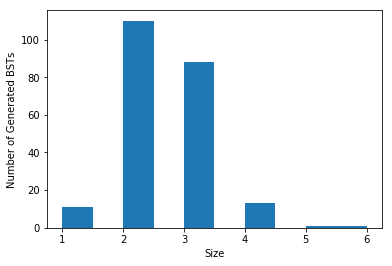

In [26]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in bsts]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))
print()

Hmm, looks like even though our naive random generator was able to generate some binary search trees, they weren't very complex. It had difficulty randomly creating valid binary search trees with more than 3 nodes, because it's randomly choosing which values to put in the tree with its Select operators.

What if we made those select operators smarter? In particular, what if we used reinforcement learning to decide what to do at each selection operator?

Let's start by defining a simple learner following a monte-carlo control policy. 

In [27]:
from numpy.random import binomial
from collections import defaultdict

class MCCLearner:

    def __init__(self,  epsilon=0.25, gamma=1.0, initial_val=0):
        self.epsilon = epsilon
        self.gamma = gamma
        self.episode = []
        self.initial_val = initial_val
        self.Q_table = defaultdict(dict)
        self.C_table = defaultdict(dict)

    # updates upon full episodes
    def reward(self, reward):
         # reward the last choice
         self.episode[-1][2] = reward
         T = len(self.episode)
         G = 0
         W = 1
         for i in range(T):
             s, a, r = self.episode[T - i - 1] # ranges from T-1, T-2, ... 0.
             G = self.gamma*G + r
             self.C_table[s][a] = self.C(s, a) + W
             self.Q_table[s][a] = self.Q(s, a) + (W/self.C(s, a)) * (G - self.Q(s, a))
         self.episode = []

    def Q(self, s: str, a: str):
        try:
            return self.Q_table[s][a]
        except KeyError:
            return self.initial_val

    def C(self, s: str, a: str):
        try:
            return self.C_table[s][a]
        except KeyError:
            return self.initial_val

    def policy(self, domain, state):
        domain = list(domain)
        # Epsilon-greedy strategy
        if binomial(1, self.epsilon):
            choice = random.choice(domain)
        else:
            self.action_values = np.array([self.Q(state, a) for a in domain])
            action_idx = random.choice(np.flatnonzero(self.action_values == self.action_values.max())) # break ties randomly
            choice = domain[action_idx]
        self.episode.append([state, choice, 0])
        return choice


We can now use these learners to back all our calls to Select. 

In [29]:
from typing import Callable, Optional, Collection

from atlas.operators import OpInfo
from atlas.strategies import RandStrategy, operator


class MCCStrategy(RandStrategy):
    
    def __init__(self):
        super().__init__()
        self.learners = {}
    
    def get_learner(self, sid):
        if sid not in self.learners:
            self.learners[sid] = MCCLearner()
        return self.learners[sid]
    
    def reward(self, r):
        for learner in self.learners.values():
            learner.reward(r)
        
    @operator
    def Select(self, domain, op_info=None, context=None, **kwargs):
        sid = op_info.sid
        learner = self.get_learner(sid)
        choice = learner.policy(domain, tuple(context))
        return choice


Now, we just need to modify our generator to add some minimal context for each call:

In [32]:
WINDOW_SIZE = 4
def concat_tail(lst, val):
    return (lst + [val])[-WINDOW_SIZE:]

@generator
def generate_tree(context, depth=0):
    value = Select(range(0, 11), context=context)
    
    # Add the last choice of value to the context
    context = concat_tail(context, value)
    tree = BinarySearchTree(value)
    
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the left child now
        tree.left = generate_tree(concat_tail(context, "LEFT"), depth+1)
        
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the right child now
        tree.right = generate_tree(concat_tail(context, "RIGHT"), depth+1) 
        
    return tree 

Let's try fuzzing again, this time rewarding the strategy if it generates a new binary search tree:

In [35]:
# Keep track of the valid BSTs we generate
def fuzz():
    num_bsts = 0
    unique_bsts = set()
    mcc_strategy = MCCStrategy()
    generate_tree.set_default_strategy(mcc_strategy)
    
    for n in range(1, TRIALS + 1):
        tree = generate_tree.call([])
        tree_repr = repr(tree)
        
        if tree.is_bst():
            num_bsts += 1
            if tree_repr not in unique_bsts:
                unique_bsts.add(tree_repr)
                mcc_strategy.reward(20)
            else:
                mcc_strategy.reward(0)
        else:
            mcc_strategy.reward(-1)

        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
    return unique_bsts
        

In [37]:
bsts = fuzz()

494 trials, 342 binary search trees, 27 unique BSTs

1022 trials, 688 binary search trees, 49 unique BSTs

1429 trials, 916 binary search trees, 79 unique BSTs

1801 trials, 1099 binary search trees, 100 unique BSTs

2246 trials, 1370 binary search trees, 134 unique BSTs

3153 trials, 1895 binary search trees, 196 unique BSTs

3554 trials, 2108 binary search trees, 236 unique BSTs

3927 trials, 2278 binary search trees, 271 unique BSTs

4187 trials, 2414 binary search trees, 292 unique BSTs

4586 trials, 2618 binary search trees, 315 unique BSTs

4967 trials, 2816 binary search trees, 345 unique BSTs

5728 trials, 3194 binary search trees, 405 unique BSTs

6125 trials, 3406 binary search trees, 444 unique BSTs

6509 trials, 3606 binary search trees, 473 unique BSTs

7317 trials, 4064 binary search trees, 534 unique BSTs

7734 trials, 4289 binary search trees, 576 unique BSTs

8172 trials, 4538 binary search trees, 617 unique BSTs

8569 trials, 4761 binary search trees, 660 unique BSTs

8952 trials, 4954 binary search trees, 696 unique BSTs

9349 trials, 5158 binary search trees, 743 unique BSTs

9750 trials, 5357 binary search trees, 782 unique BSTs

Cool! We generated ~4x more binary search treest than the random strategy. Are they of more diverse sizes as well?

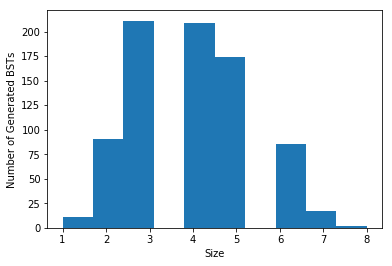

In [38]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in bsts]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))
print()

Looks like it! We see tons of trees of sizes 4 and 5, and even some of sizes 6 and 7!